# **TASK:** to create neural network with numpy for regression and classification tasks

In [0]:
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [0]:
class NeuralNetwork(object):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate, beta, type_nn):
        self.inputSize = input_size
        self.hiddenSize1 = hidden_size1
        self.hiddenSize2 = hidden_size2
        self.outputSize = output_size
        self.learning_rate = learning_rate
        self.beta = beta
        self.type_nn = type_nn
        self.loss_dict_clas = []
        self.loss_dict_regr = []
        self.acc_dict_clas = []
        
        self.W1 = np.random.normal(0, 0.03, (self.inputSize, self.hiddenSize1))
        self.b1 = np.ones((self.hiddenSize1, 1))
        self.W2 = np.random.normal(0, 0.03, (self.hiddenSize1, self.hiddenSize2))
        self.b2 = np.ones((self.hiddenSize2, 1))
        self.W3 = np.random.normal(0, 0.03, (self.hiddenSize2, self.outputSize))
        self.b3 = np.ones((self.outputSize, 1))
    
    def softmax(self, X, deriv = False):
        if (deriv == True):
            return np.array([it * (1 - it) for it in X])
        else:
            exp_X = np.exp(X)
            exp_X_sum = np.sum(exp_X, axis=1).reshape(-1, 1)
            exp_X = (exp_X / exp_X_sum)
            return exp_X
    
    def sigmoid(self, s, deriv=False):
        if (deriv == True):
            return s * (1 - s)
        return 1/(1 + np.exp(-s))
    
    def relu(self, X):
        return np.maximum(0, X)
    
    def preprocess_data(self, X, y):
        data = np.array(X).reshape(-1, self.inputSize)
        if self.type_nn == 'clas':
            labels = np.zeros([data.shape[0], self.outputSize])
            for i, label in enumerate(y):
                labels[i,label] = 1
            y = labels
        else:
            self.max_y_regr = np.max(y)
            y = y / np.max(y)

        for i in range(self.inputSize):
            mean = data[:,i].mean()
            std = data[:,i].std()
            data[:,i] = (data[:,i] - mean) / std
        return data, y

    def feedForward(self, X):
        self.z1 = np.array(self.sigmoid(np.matmul(X, self.W1) + self.b1.T)).reshape(len(X), self.hiddenSize1)
        self.z2 = np.array(self.sigmoid(np.matmul(self.z1, self.W2) + self.b2.T)).reshape(len(X), self.hiddenSize2)
        z3 = np.matmul(self.z2, self.W3) + self.b3.T
        if self.type_nn == 'clas': 
            output = np.array(self.softmax(z3)).reshape(len(X), self.outputSize)
        else:
            output = np.array(self.relu(z3)).reshape(len(X), 1)
        return output
    
    def backward(self, X, y, output):
        if self.type_nn == 'clas':
            self.output_error = self.loss_categorical(y, output, deriv = True)
        else:
            self.output_error = output - y
        self.A2 = np.multiply(np.matmul((self.output_error), self.W3.T), self.sigmoid(self.z2, deriv = True))
        self.A1 = np.multiply(np.matmul((self.A2), self.W2.T), self.sigmoid(self.z1, deriv = True))
        
        self.part_der3 = np.matmul(self.z2.T, self.output_error) / len(X)
        self.part_der2 = np.matmul(self.z1.T, self.A2) / len(X)
        self.part_der1 = np.matmul(X.T, self.A1) / len(X)
        
        self.W1 -= self.learning_rate * (self.part_der1)
        self.W2 -= self.learning_rate * (self.part_der2)
        self.W3 -= self.learning_rate * (self.part_der3)
    
    def loss_categorical(self, y, y_pred, deriv = False):
        if (deriv == True):
            return y_pred - y
        else:
            return -1 * np.sum(y * np.log(y_pred))

    def calc_loss_acc(self, y, y_pred):
        acc = 0
        loss = 0
        if self.type_nn == 'clas':
            loss = self.loss_categorical(y, y_pred)
            acc = np.sum(np.argmax(y, axis=1)==np.argmax(y_pred, axis=1)) / len(y)
            self.loss_dict_clas.append(loss)
            self.acc_dict_clas.append(acc)
        else:
            loss = mean_squared_error(y * self.max_y_regr, (y_pred * self.max_y_regr))
            self.loss_dict_regr.append(loss)
    
    def predict(self, X):
        output = self.feedForward(X)
        return output
    
    def train(self, X, y, iterations = 2):
        prep_X, prep_y = self.preprocess_data(X, y)
        x_tr, x_val, y_tr, y_val = train_test_split(prep_X, prep_y, test_size = 0.1, random_state=17)
        for index in range(iterations):
            output = self.feedForward(x_tr)
            self.backward(x_tr, y_tr, output)
            self.calc_loss_acc(y_tr, output)
            if index % 5000 == 0:
                output_val = self.feedForward(x_val)
                print('\n\nIteration {}'.format(index))
                if self.type_nn == 'clas':
                    print('loss = {}'.format(self.loss_dict_clas[-1]))
                    print('accuracy = {}'.format(self.acc_dict_clas[-1] * 100))
                    print('Predict = {}'.format(np.round(output_val[0:10])))
                else:
                    print('loss = {}'.format(self.loss_dict_regr[-1]))
                    print('Predict = {}'.format(output_val[0:10]))
                print('True = {}'.format(y_val[0:10]))
    
    def train_hybrid(self, X_regr, y_regr, X_clas, y_clas):
        self.type_nn = 'clas'
        self.train(X_clas, y_clas)
        selt.type_nn = 'regr'
        self.train(X_regr, y_regr)

### Load data

In [0]:
from sklearn.datasets import load_breast_cancer, load_boston, load_iris

breast = load_breast_cancer()
data_breast = breast.data
target_breast = breast.target

boston = load_boston()
data_boston = boston.data
target_boston = boston.target

iris = load_iris()
data_iris = iris.data
target_iris = iris.target

In [0]:
print(f'breast_data = {data_breast.shape}\nunique classes breast = {np.unique(target_breast)}\n\n'
f'data_boston = {data_boston.shape}\ndata target example = {target_boston[7]}\n\n'
f'data iris = {data_iris.shape}\nunique iris target = {np.unique(target_iris)}')

breast_data = (569, 30)
unique classes breast = [0 1]

data_boston = (506, 13)
data target example = 27.1

data iris = (150, 4)
unique iris target = [0 1 2]


In [0]:
data_breast

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [0]:
z = list(zip(data_breast, target_breast))
np.random.shuffle(z)
z = np.array(z)
data_breast, target_breast = zip(*z)

z = list(zip(data_boston, target_boston))
np.random.shuffle(z)
z = np.array(z)
data_boston, target_boston = zip(*z)

data_breast = np.array(data_breast); target_breast = np.array(target_breast)
data_boston = np.array(data_boston); target_boston = np.array(target_boston)

x_train_breast, x_test_breast, y_train_breast, y_test_breast = train_test_split(data_breast, target_breast, test_size = 0.2)
x_train_boston, x_test_boston, y_train_boston, y_test_boston = train_test_split(data_boston, target_boston, test_size = 0.2)
x_train_iris, x_test_iris, y_train_iris, y_test_iris = train_test_split(data_iris, target_iris, test_size = 0.2)

In [0]:
x_train_breast.shape, x_train_boston.shape, x_train_iris.shape

((455, 30), (404, 13), (120, 4))

In [0]:
x_test_breast[0]

array([1.578e+01, 2.291e+01, 1.057e+02, 7.826e+02, 1.155e-01, 1.752e-01,
       2.133e-01, 9.479e-02, 2.096e-01, 7.331e-02, 5.520e-01, 1.072e+00,
       3.598e+00, 5.863e+01, 8.699e-03, 3.976e-02, 5.950e-02, 1.390e-02,
       1.495e-02, 5.984e-03, 2.019e+01, 3.050e+01, 1.303e+02, 1.272e+03,
       1.855e-01, 4.925e-01, 7.356e-01, 2.034e-01, 3.274e-01, 1.252e-01])

### Create NN and train it (classification task)

In [0]:
nn_breast_clas = NeuralNetwork(30, 4,4, 2, 0.01, 0.00001, type_nn = 'clas')

In [0]:
x_test_breast, y_test_breast = nn_breast_clas.preprocess_data(x_test_breast, y_test_breast)

In [0]:
nn_breast_clas.train(x_train_breast, y_train_breast, iterations=50001)



Iteration 0
loss = 282.6107486175603
accuracy = 62.59168704156479
Predict = [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
True = [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


Iteration 5000
loss = 270.1614316527751
accuracy = 62.59168704156479
Predict = [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
True = [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


Iteration 10000
loss = 268.3740122773882
accuracy = 62.59168704156479
Predict = [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
True = [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


Iteration 15000
loss = 125.43365534760676
accuracy = 94.86552567237165
Predict = [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
True = [[0. 1.]
 [

In [0]:
loss_dict = nn_breast_clas.loss_dict_clas
len(loss_dict)

50001

In [0]:

# nn_boston_regr.train(x_train_boston, y_train_boston.reshape(len(y_train_boston), -1), iterations=100000)

### Test classification

In [0]:
y_test_breast[50:60]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [0]:
res = np.round(nn_breast_clas.predict(x_test_breast), 0)
res[50:60]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [0]:
accuracy_score(y_test_breast, res)

0.9736842105263158

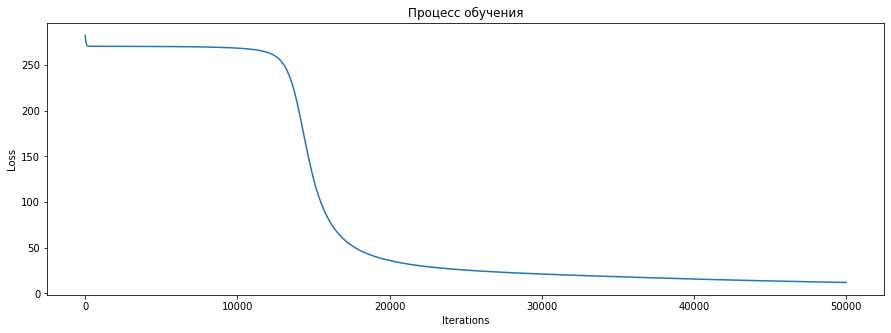

In [0]:
plt.figure(figsize=(15,5))
plt.plot(list(range(1,len(loss_dict))),loss_dict[1:])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Процесс обучения')
plt.show()

### Train regression NN and test it

In [0]:
nn_boston_regr = NeuralNetwork(13, 4, 4, 1, 0.03, 0.00001, type_nn = 'regr')

In [0]:
x_test_boston, y_test_boston = nn_boston_regr.preprocess_data(x_test_boston, y_test_boston)

In [0]:
nn_boston_regr.train(x_train_boston, y_train_boston.reshape(len(y_train_boston), -1), iterations=50001)



Iteration 0
loss = 1073.0461975702897
Predict = [[1.04216819]
 [1.04216255]
 [1.04213758]
 [1.04216293]
 [1.04211039]
 [1.04210885]
 [1.04211362]
 [1.04212669]
 [1.04217776]
 [1.04213275]]
True = [[0.382]
 [0.328]
 [0.388]
 [0.398]
 [0.574]
 [0.58 ]
 [0.528]
 [0.42 ]
 [0.358]
 [0.502]]


Iteration 5000
loss = 83.6555709103113
Predict = [[0.45286593]
 [0.45275143]
 [0.45303734]
 [0.45280992]
 [0.45329045]
 [0.45357992]
 [0.45319512]
 [0.45319025]
 [0.45239803]
 [0.45314243]]
True = [[0.382]
 [0.328]
 [0.388]
 [0.398]
 [0.574]
 [0.58 ]
 [0.528]
 [0.42 ]
 [0.358]
 [0.502]]


Iteration 10000
loss = 83.24775640611213
Predict = [[0.45212149]
 [0.45181478]
 [0.45278188]
 [0.45191729]
 [0.45372889]
 [0.45451323]
 [0.45326114]
 [0.45322851]
 [0.45033297]
 [0.4534402 ]]
True = [[0.382]
 [0.328]
 [0.388]
 [0.398]
 [0.574]
 [0.58 ]
 [0.528]
 [0.42 ]
 [0.358]
 [0.502]]


Iteration 15000
loss = 81.65061426880443
Predict = [[0.44925619]
 [0.44819557]
 [0.45193505]
 [0.44840165]
 [0.455544  ]
 [0.45

In [0]:
y_test_boston[20:40] * np.max(target_boston)

array([28.6, 18.8, 20.1, 19.1, 21.9, 25. ,  8.8, 22.6, 37.6, 17.8, 20. ,
       17.2, 22.6,  7. , 13.8, 18.9, 28. ,  7.5, 28.5, 37.2])

In [0]:
(nn_boston_regr.predict(x_test_boston) * np.max(target_boston))[20:40]

array([[28.05083819],
       [21.20403921],
       [19.59941653],
       [17.3325155 ],
       [40.50593111],
       [25.41510538],
       [ 6.48620134],
       [21.97119358],
       [37.42331527],
       [24.23278228],
       [19.66712987],
       [13.75548669],
       [25.30806228],
       [ 3.04061023],
       [21.305038  ],
       [21.59014674],
       [28.41037242],
       [12.85334294],
       [31.77025192],
       [32.02910538]])

In [0]:
mean_squared_error(y_test_boston * np.max(target_boston), (nn_boston_regr.predict(x_test_boston) * np.max(target_boston)))

21.03913211968472